<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">



# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Projeto de Data Wrangling sobre logísticas da Startup Loggi, geração de visualizações e retirada de insights tendo como foco o Distrito Federal. Também tendo como objeto responder:
*   Questão 1: A localização dos Hubs é eficiente?
*   Questão 2: A distribuição de veículos pode ser melhorada?

In [116]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx


replace ./maps/ASB_Cemiterio_A.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
A
A


## 2\. Pacotes e bibliotecas

In [117]:
!pip3 install geopandas

import json

import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

## 3\. Exploração de dados

###**3.1** Carregamento dos Dados

O dado bruto está disponível para download neste [link](https://github.com/andre-marcos-perez/ebac-course-utils/blob/main/dataset/deliveries.json). Vamos realizar o seu download num arquivo JSON com o nome deliveries.json.

In [123]:
#Carregando dados em um dicinonário Python
with open('/content/deliveries.json', mode='r', encoding='utf8') as file:
    data = json.load(file)

#Passando dict para DataFrame
deliveries_df = pd.DataFrame(data)

#Visualizando
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [124]:
#Visualizando dimensões iniciais do DataFrame
deliveries_df.shape

(199, 5)

###**3.2** Data Wrangling

A coluna origin possue dados aninhados. Vamos normalizar a coluna com uma operação conhecida como `flatten` ou achatamento.

In [125]:
deliveries_origin_df = pd.json_normalize(deliveries_df['origin'])
deliveries_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


Com o dados achatados, vamos junta-los ao conjunto de dados principal:

In [126]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


Eliminado a coluna origin, reorganizando e renomeando o DataFrame

In [127]:
deliveries_df = deliveries_df.drop('origin', axis=1)
deliveries_df = deliveries_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


A coluna deliveries também possue dados aninhados, porem por ser uma lista é primeiro necessário utilizar uma operação conhecida como `explode` para depois utilizar o `flatten` enquanto concateno os dados a um novo DataFrame.

In [128]:
deliveries_explode_df = deliveries_df[["deliveries"]].explode('deliveries')
deliveries_explode_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [129]:
deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_explode_df["deliveries"].apply(lambda record: record['size'])).rename(columns={"deliveries": "delivery_size"}),
    pd.DataFrame(deliveries_explode_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
    pd.DataFrame(deliveries_explode_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
],axis= 1)
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


Agora podemos combina-los ao conjunto de dados principal e retirar a coluna deliveries

In [130]:
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


###**3.3** Análise de estrutura e schema

Agora, com os dados estruturados, partiremos para análisar sua estrutura

In [131]:
#Verificando dimensões
deliveries_df.shape

(636149, 8)

In [132]:
#Verificando os tipos de dados e se há valores nulos
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


 - Atributos **categóricos**.

In [133]:
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


Depois do data Wrangling a quantidade de valores únicos é a mesma dos valores iniciais e quase metade das entregas vão para a região df-1

 - Atributos **numéricos**.

In [134]:
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


Todos os veículos possuem mesma capacidade, o tamanho da estregas costuma ser 5 com desvios entre 3 e 8.


## 4\. Manipulação

###**4.1** Geocodificação reversa do hub

Utilizaremos o processo de Geocodificação reversa na localização dos hubs

In [135]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Vamos então aplicar a geocodificação nas coordenadas das três regiões e extrair informações de **cidade** e **bairro**.

In [136]:
geolocator = Nominatim(user_agent="geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)
hub_df["cordinates"] = hub_df["hub_lat"].astype(str) + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["cordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,cordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [137]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172753950067,-47.89372354453109,highway,residential,26,0.053411,...,Distrito Federal,BR-DF,Região Centro-Oeste,70336-000,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


Pare evitar dados nulos quando não ouver `hub_city` teremos o dado `hub_town` e quando não tivermos o `hub_suburb` teremos `hub_city`

In [138]:
import numpy as np

hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]].copy()
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df.loc[:, "hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df.loc[:, "hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


Por fim temos o DataFrame `deliveries_df` com as informações de **cidade** e **bairro**.

In [139]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [140]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


###**4.2** Geocodificação reversa da entrega

Os Dados da geocodificação reversa das entregas está neste link [link](https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv).

In [141]:
deliveries_geodata_df = pd.read_csv("/content/deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [142]:
#Unindo dados da entrega ao DataFrame original
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


###**4.3** Verificando Qualidade

Criar um dicionário dos campos com a descrição e tipo de cada variável.

In [143]:
df = pd.DataFrame(deliveries_df)

# Exemplo de descrições para cada coluna (isso pode ser ajustado conforme necessário)
descricoes = {
    'name': 'Nome',
    'region': 'Região da entrega',
    'hub_lng': 'Longitude do hub',
    'hub_lat': 'Latitude do hub',
    'hub_city': 'Cidade do hub',
    'hub_suburb': 'Bairro do hub',
    'vehicle_capacity': 'Capacidade de veículo',
    'delivery_size': 'Tamanho da entrega',
    'delivery_lng': 'Longitude da entrega',
    'delivery_lat': 'Latitude da entrega',
    'delivery_city': 'Cidade da entrega',
    'delivery_suburb': 'Bairro da entrega',
}

# Criar o dicionário com tipos de dados e descrições
dicionario = {}
for coluna in df.columns:
    dicionario[coluna] = {
        'tipo': str(df[coluna].dtype),
        'descricao': descricoes.get(coluna, 'Sem descrição')  # Adiciona a descrição ou 'Sem descrição' se não houver
    }

# Mostrar o dicionário
for campo, detalhes in dicionario.items():
    print(f"Campo: {campo}, Tipo: {detalhes['tipo']}, Descrição: {detalhes['descricao']}")

# Para salvar em um arquivo JSON (opcional)
import json
with open('dicionario.json', 'w', encoding='utf-8') as f:
    json.dump(dicionario, f, ensure_ascii=False, indent=4)

Campo: name, Tipo: object, Descrição: Nome
Campo: region, Tipo: object, Descrição: Região da entrega
Campo: hub_lng, Tipo: float64, Descrição: Longitude do hub
Campo: hub_lat, Tipo: float64, Descrição: Latitude do hub
Campo: hub_city, Tipo: object, Descrição: Cidade do hub
Campo: hub_suburb, Tipo: object, Descrição: Bairro do hub
Campo: vehicle_capacity, Tipo: int64, Descrição: Capacidade de veículo
Campo: delivery_size, Tipo: int64, Descrição: Tamanho da entrega
Campo: delivery_lng, Tipo: float64, Descrição: Longitude da entrega
Campo: delivery_lat, Tipo: float64, Descrição: Latitude da entrega
Campo: delivery_city, Tipo: object, Descrição: Cidade da entrega
Campo: delivery_suburb, Tipo: object, Descrição: Bairro da entrega


In [144]:
#Porcentagem de valores nulos em delivery_city
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [145]:
#Verificando valores mais comuns em delivery_city
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
Name: count, dtype: float64

In [146]:
#Porcentagem de valores nulos em delivery_suburb
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [147]:
#Verificando valores mais comuns em delivery_suburb
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
Name: count, dtype: float64

Identificamos alguns valores nulos em delivery_city e muitos valores nulos em delivery_suburb

## 5\. Visualização

###**5.1** Mapa de entregas por região

Vamos fazer o download dos dados do mapa do Distrito Federal do site oficial do IBGE através do seguinte [link](https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas)

In [176]:
#Gerando DataFrame com geopandas
mapa = gpd.read_file("/content/distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON ((-48.25047 -15.97565, -48.25036 -15.9..."


 - **Mapa dos Hubs**

Vamos criar o DataFrame geo_hub_df através do DataFrame deliveries_df

In [177]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = gpd.GeoDataFrame(hub_df, geometry=gpd.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


 - **Mapa das Entregas**

Vamos criar o DataFrame geo_deliveries_df através do DataFrame deliveries_df

In [178]:
geo_deliveries_df = gpd.GeoDataFrame(deliveries_df, geometry=gpd.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


 - **Visualização**

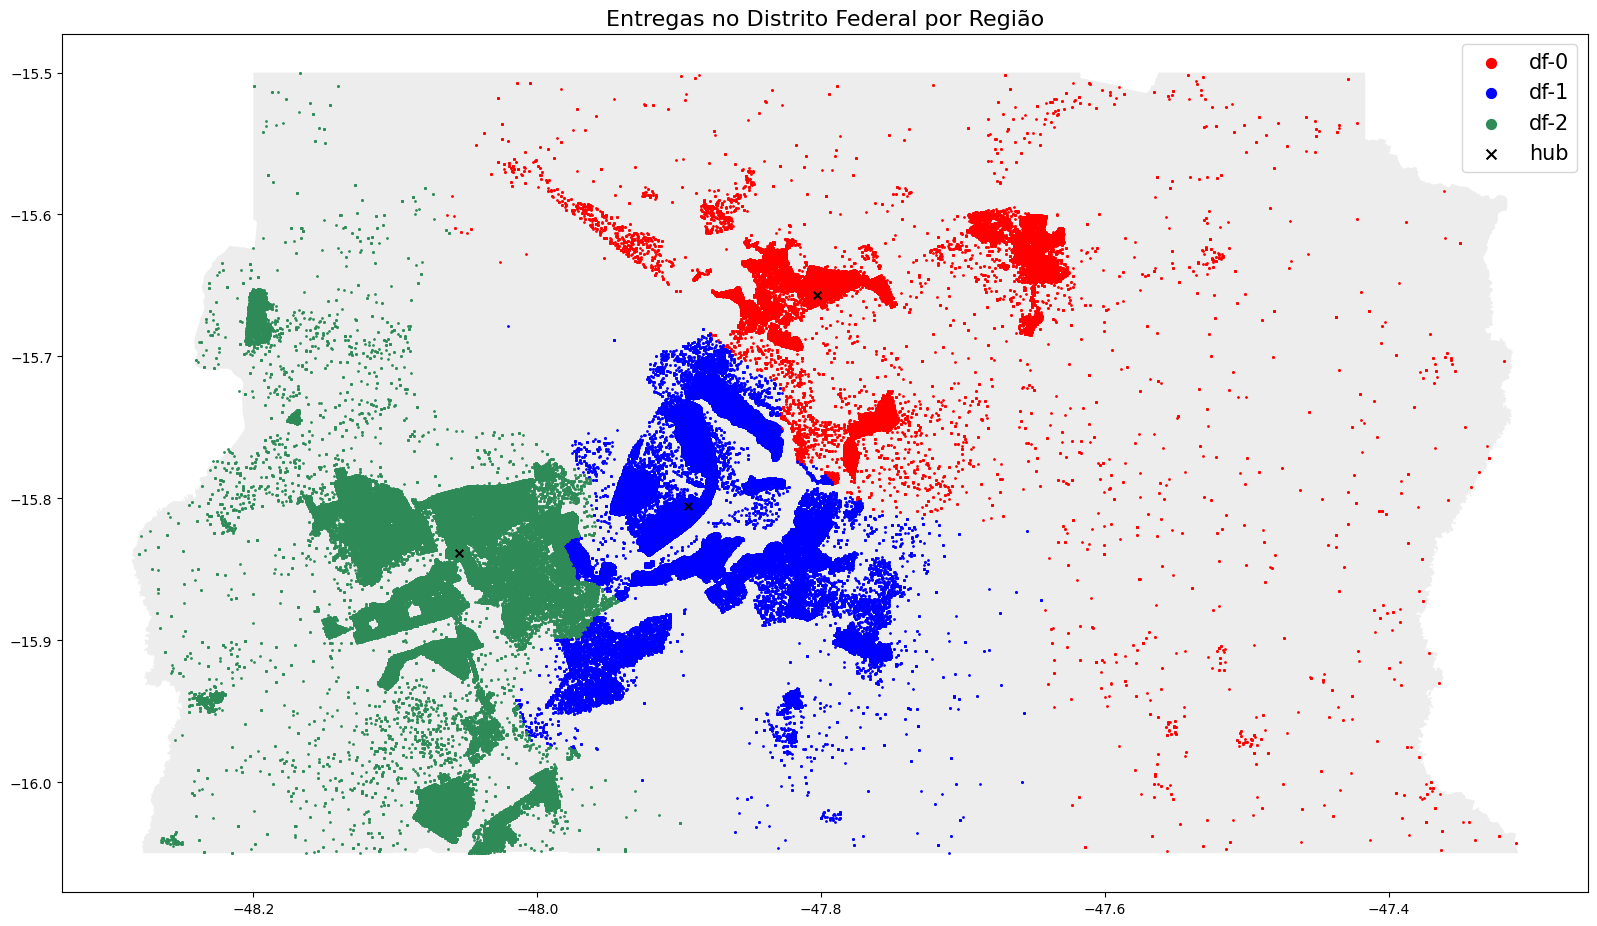

In [174]:
#Criar plot vazio
fig, ax = plt.subplots(figsize = (50 / 2.54, 50 / 2.54))

#Plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legend_handles:
    handle._sizes = [50]

 - **Insights**:

1. O **hub** da região 1 possui entregas menos dispersas, o que pode significar maior facilidade com as entregas.
1. Os **hubs** das regiões 0 e 2 fazem **entregas** em locais distantes do centro e entre si, o que pode gerar um tempo e preço de entrega maior.

### **5.2. Gráfico de entregas por região**

 - **Agregação**:

In [163]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.head()

,region,vehicle_capacity,proportion
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


 - **Visualização**:

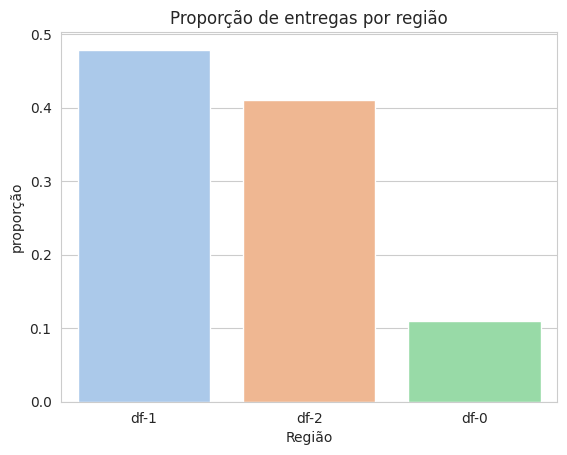

In [164]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="proportion", hue="region", errorbar=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='proporção');

 - **Insights**:

1. A distribuição das **entregas** está muito concentrada nos **hubs** das regiões 1 e 2, mas pouco no da região 0. Contudo a capacidade dos veículos é mesma para todos os **hubs**, logo os **veículos** poderiam ser deslocados para as regiões de maior tráfego.

### **5.3. gráfico de proporção de entregas por cidades**

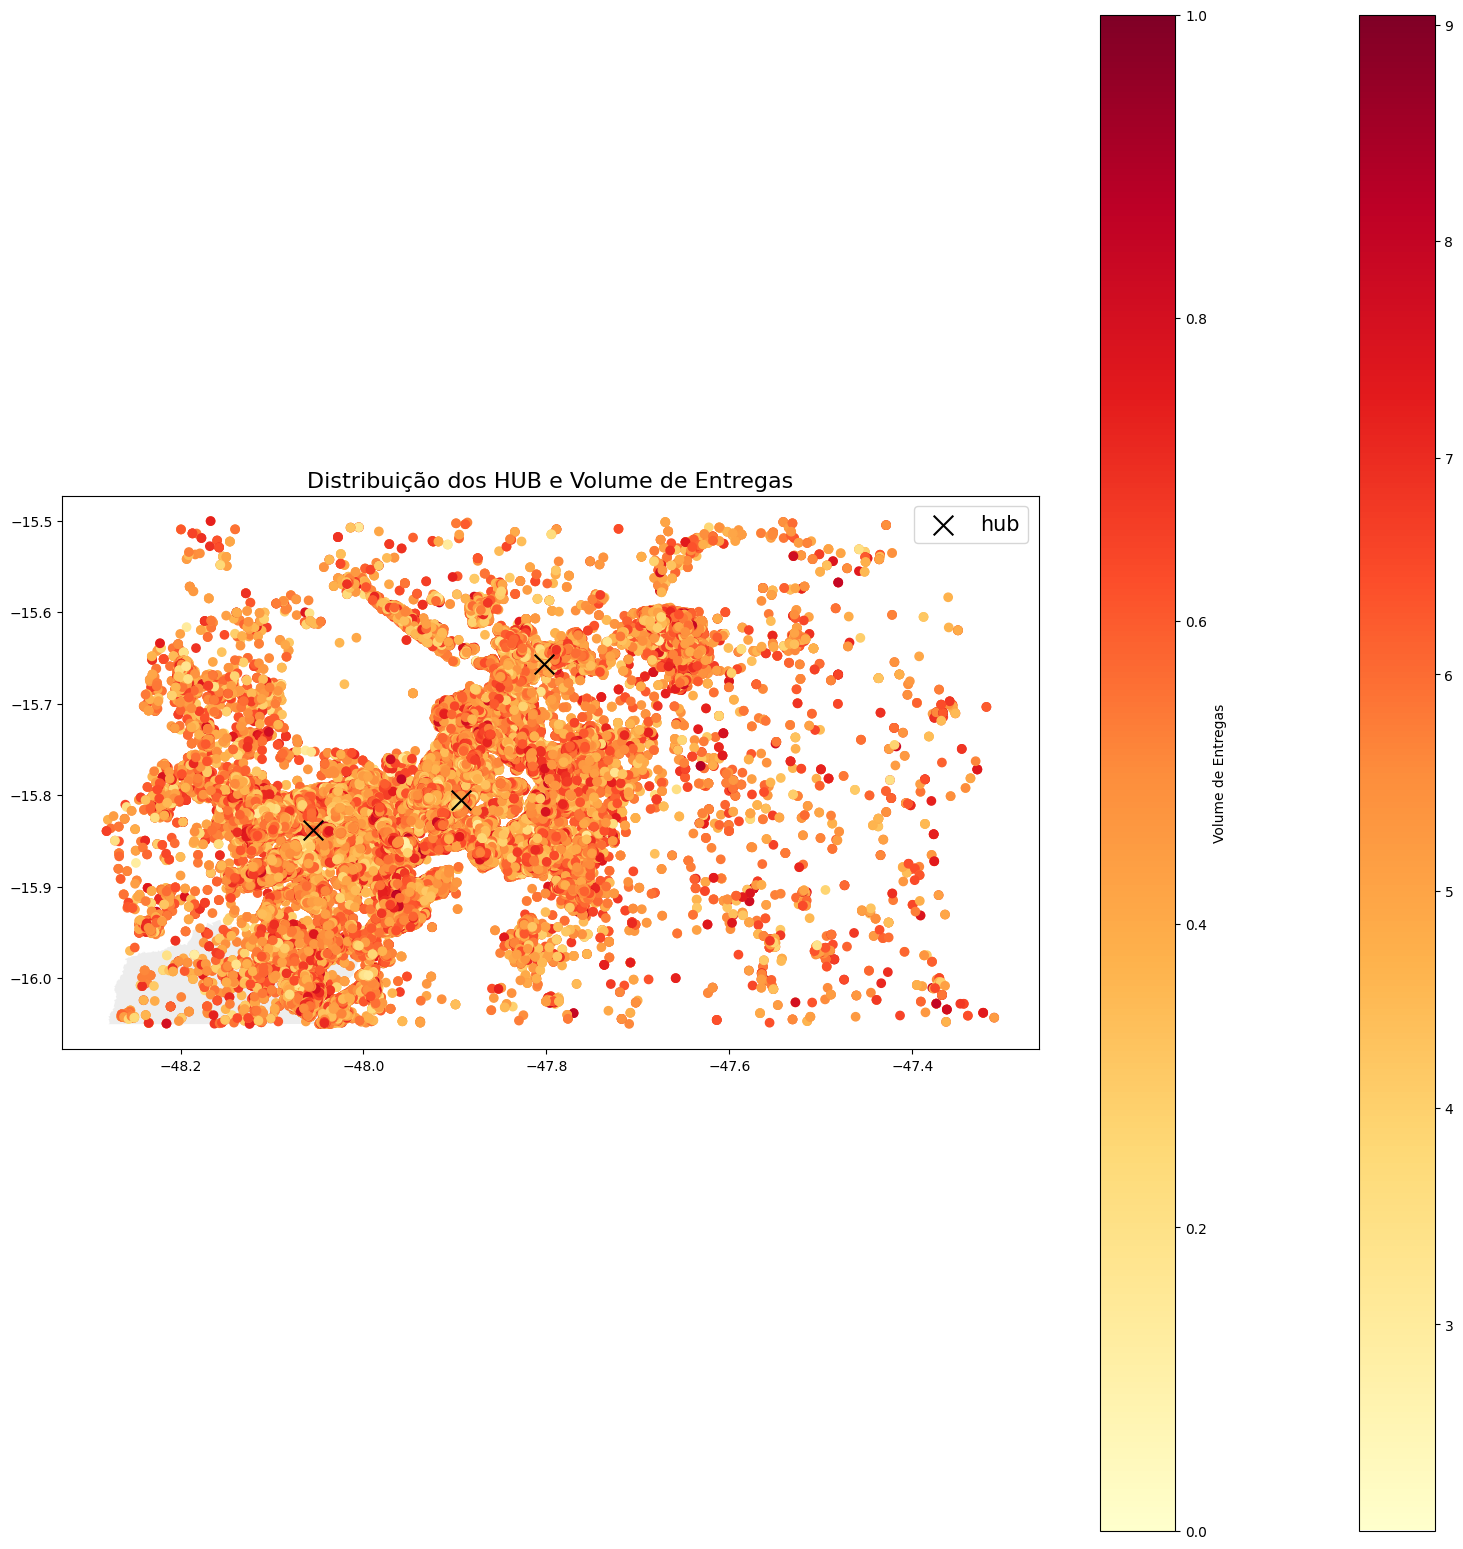

In [179]:
# Vamos usar o volume de entregas
geo_deliveries_df["volume"] = geo_deliveries_df["delivery_size"].ewm(span=10).mean()

#Criar plot vazio
fig, ax = plt.subplots(figsize = (50 / 2.54, 50 / 2.54))

# Plot do mapa do Distrito Federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# Plot das delimitações com cores baseadas no volume de entregas
geo_deliveries_df["color"] = geo_deliveries_df["volume"]
geo_deliveries_df.plot(column="color", cmap="YlOrRd", legend=True, ax=ax, linewidth=1)

# Plot dos hubs
geo_hub_df.plot(ax=ax, markersize=200, marker="x", color="black", label="hub")

# Título do gráfico
plt.title("Distribuição dos HUB e Volume de Entregas", fontdict={"fontsize": 16})

# Adicione a legenda
legenda = plt.legend(prop={"size": 15})

# Ajuste a legenda para a escala de cores
sm = plt.cm.ScalarMappable(cmap="YlOrRd")
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Volume de Entregas")

plt.show()
